# Random Forest and Logistic regression 

### Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
data=pd.read_csv('data_snow_tree.csv')
data.head()

,VZmax,VPzabove1,VPzabove3,VPzabove4,VZq90,VZq95,VFHD,VSlope,VAspect,Depth
0,20.200,99.752129,88.107317,81.332597,15.9854,17.2050,2.536217,17.752318,172.106556,0.607861
1,9.410,97.875464,59.896416,43.401041,6.5660,7.3340,2.008234,1.222789,169.351610,1.000316
2,19.564,99.810375,96.153325,84.653935,17.2290,17.8950,2.255792,2.839515,166.139445,0.884730
3,14.431,97.085151,59.967064,41.881313,7.4800,8.3000,1.568804,22.447919,310.658943,0.948709
4,25.519,99.001252,73.539449,66.172511,18.1640,20.3701,3.031498,15.289915,161.095405,0.691791


As the snow depth is continuous data, we assign class labels to the snow depth by average depth increase and make binary class.


In [3]:
y = np.array(data['Depth'])
X = np.array(data.iloc[:,:9])

cls = y>np.mean(y)
y = cls*1

### Standardizing the features value

In [4]:
X_std = StandardScaler().fit_transform(X)

### Feature Importance with forests of trees

#### Mean decrease impurity

Feature ranking:
1. feature VZmax (0.138479)
2. feature VZq95 (0.124037)
3. feature VZq90 (0.121860)
4. feature VPzabove4 (0.107653)
5. feature VPzabove1 (0.107287)
6. feature VFHD (0.102611)
7. feature VAspect (0.102163)
8. feature VPzabove3 (0.099955)
9. feature VSlope (0.095955)


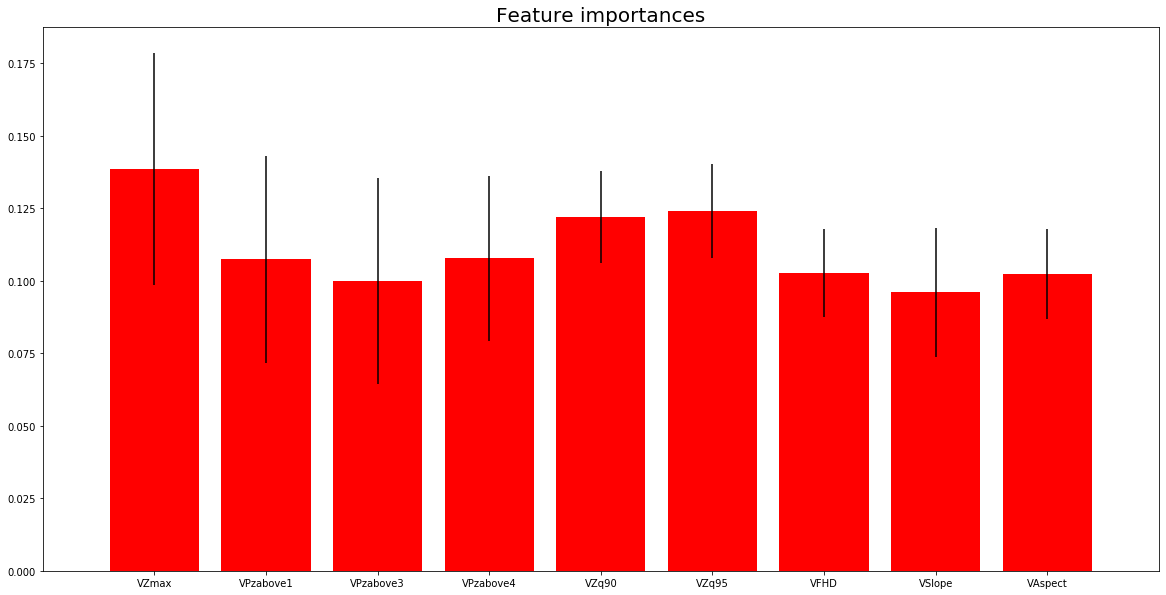

In [5]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=1234)

forest.fit(X_std, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

names = list(data.columns)
# Print the feature ranking
print("Feature ranking:")

for f in range(X_std.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances",fontsize=20)
plt.bar(names[0:-1], importances,color="r", yerr=std[indices], align="center")
# plt.xticks(range(X_std.shape[1]), names[indices])
plt.xlim([-1, X_std.shape[1]])
plt.show()

Feature importance is important in a model prediction and provides insight into the data, the model, and is the basis for dimensionality reduction and feature selection that can improve the efficiency of a model prediction. In case we have dependent features we can apply PCA on those datasets to have independent features and use the transformed data (reduced features) in modeling but PCA does not show which of those original features are more effective in our estimation.

There are a few things to keep in mind when using the impurity based ranking. Firstly, feature selection based on impurity reduction is biased towards preferring variables with more categories. Secondly, when the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others. But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

### Logistic Regression Feature Importance

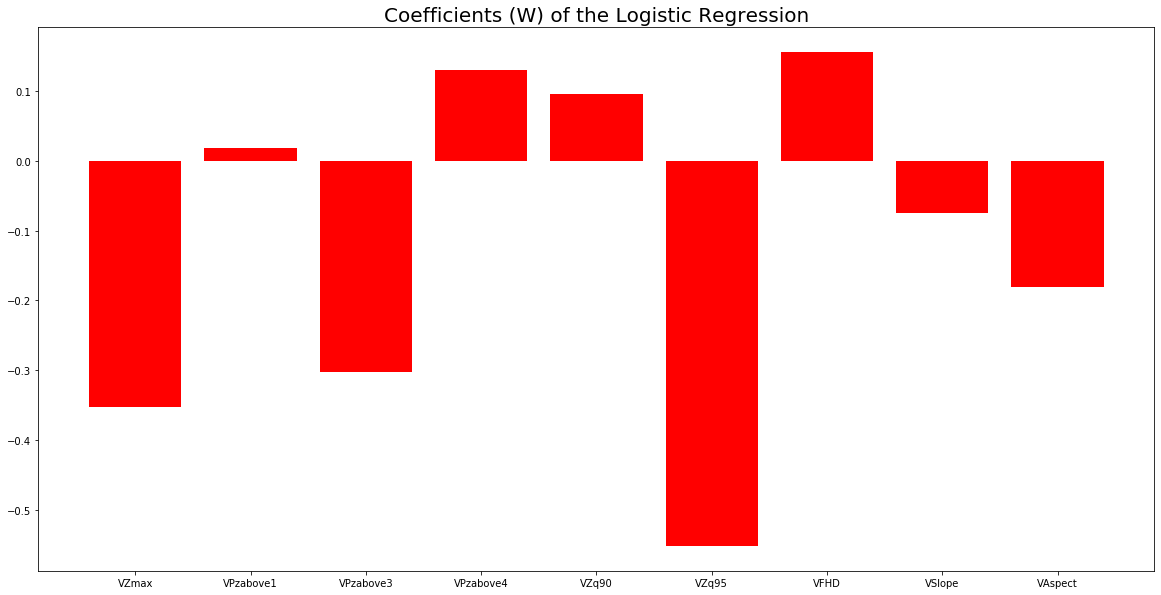

In [6]:
# List of feature names 
names = list(data.columns)

# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['Depth'], axis=1),y,test_size=0.3,random_state=1234)

# Standardize the data
X_std = StandardScaler().fit_transform(X_train)

# logistic regression fit with Ridge regularisation
lg = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
lg.fit(X_std, y_train)

# Coefficients
importance = lg.estimator_.coef_[0]

# plot feature importance
plt.figure(figsize=(20,10))
plt.title("Coefficients (W) of the Logistic Regression",fontsize=20)
plt.bar(names[0:-1], importance, color='r')
plt.show()

Random Forest works well for nonlinear cases, but in logistic regression we need to have linear model.
Correlated features in Random Forest will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts. RF and Logistic Regression methods result are different for feature importance and that's because our data features are highly correlated. 